# I. Data Cleaning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from azureml.core import Workspace, Dataset

subscription_id = 'edd414a3-1074-4950-b852-7c3fc44a2b0d'
resource_group = 'docs-aml'
workspace_name = 'docs_ws'
workspace = Workspace(subscription_id, resource_group, workspace_name)

df = Dataset.get_by_name(workspace, name='stroke_clean').to_pandas_dataframe()

# drop col 'id'
df.drop('id', axis=1, inplace=True)

# convert col 'bmi' to float and impute missing values with mean
df['bmi'] = df['bmi'].apply(lambda x: float(x) if x != 'N/A' else np.nan)
df['bmi'] = df['bmi'].fillna(df['bmi'].mean())

df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,True,Private,Urban,228.69,36.600000,formerly smoked,1
1,Female,61.0,0,0,True,Self-employed,Rural,202.21,28.893237,never smoked,1
2,Male,80.0,0,1,True,Private,Rural,105.92,32.500000,never smoked,1
3,Female,49.0,0,0,True,Private,Urban,171.23,34.400000,smokes,1
4,Female,79.0,1,0,True,Self-employed,Rural,174.12,24.000000,never smoked,1


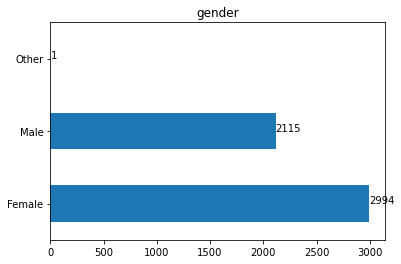

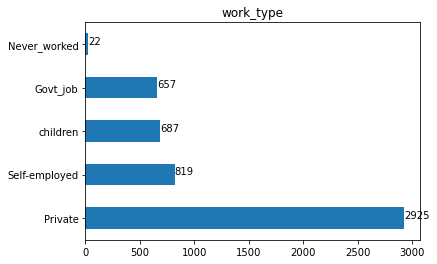

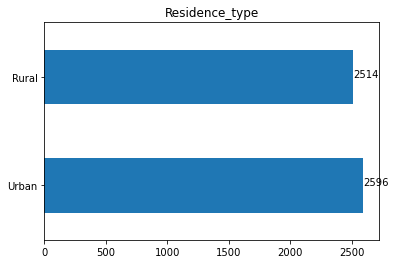

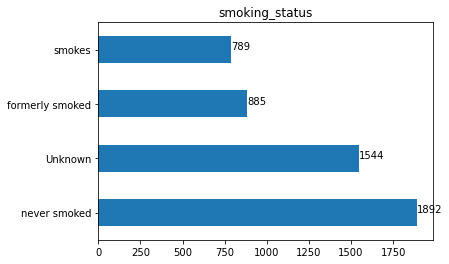

In [2]:
# categorical variables
for i in df.dtypes[df.dtypes=='object'].index:
    df[i].value_counts().plot(kind='barh')
    for k, v in enumerate(df[i].value_counts().values): plt.text(v, k, str(v))
    plt.title(i)
    plt.show()

cols = df.dtypes[(df.dtypes != 'int64') & (df.dtypes != 'float64')].index
df = pd.get_dummies(df, columns=cols, drop_first=True, dtype=np.int64)

# II. Data Modeling

In [3]:
# oversampling minority class
stroke_oversampled = df[df['stroke'] == 1].sample(len(df[df['stroke'] == 0]), replace=True)
df = pd.concat([df[df['stroke'] == 0], stroke_oversampled], axis=0)

# train test split
from sklearn.model_selection import train_test_split
X, y = df.drop('stroke', axis=1), df['stroke']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)

# evalution metrics
def evaluation(model, param):
    from sklearn.model_selection import RandomizedSearchCV
    rdm_search = RandomizedSearchCV(model, param, n_iter=50, cv=3, verbose=2, random_state=8, n_jobs=-1)
    rdm_search.fit(X_train, y_train)
    best_model = rdm_search.best_estimator_

    from sklearn import metrics
    y_test_pred = best_model.predict(X_test)
    y_train_pred = best_model.predict(X_train)
    print('classification report (train):\n'+ metrics.classification_report(y_train, y_train_pred))
    print('classification report (test):\n'+ metrics.classification_report(y_test, y_test_pred))

    print('scores (test):')
    print('\taccuracy: %.2f'% metrics.accuracy_score(y_test, y_test_pred))
    print('\tprecision: %.2f'% metrics.precision_score(y_test, y_test_pred))
    print('\trecall: %.2f'% metrics.recall_score(y_test, y_test_pred))
    print('\tf1: %.2f'% metrics.f1_score(y_test, y_test_pred))
    print('\troc auc: %.2f'% metrics.f1_score(y_test, y_test_pred))

    pred = best_model.predict_proba(X)[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y, pred)
    plt.plot(fpr, tpr, 'b', label='AUC = %.2f' % metrics.auc(fpr, tpr))
    plt.legend(loc = 'lower right')
    plt.plot([-0.01, 1.01], [-0.01, 1.01],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title('ROC Curve')
    plt.show()

    from sklearn.metrics import precision_recall_fscore_support
    rep = np.array(precision_recall_fscore_support(y_test, y_test_pred)).T
    avg = np.mean(rep, axis=0)
    avg[-1] = np.sum(rep[:, -1])
    rep = np.insert(rep, rep.shape[0], avg, axis=0)
    sns.heatmap(rep, linewidths=.5, annot=True, cbar=True, cmap='YlGnBu',
                xticklabels=['precision', 'recall', 'f1-score', 'support'], 
                yticklabels=list(np.unique(y_test)) + ['avg'])
    plt.show()

## i. logistic regression

Fitting 3 folds for each of 50 candidates, totalling 150 fits
classification report (train):
              precision    recall  f1-score   support

           0       0.82      0.71      0.76      3872
           1       0.75      0.84      0.79      3905

    accuracy                           0.78      7777
   macro avg       0.78      0.78      0.78      7777
weighted avg       0.78      0.78      0.78      7777

classification report (test):
              precision    recall  f1-score   support

           0       0.84      0.70      0.76       989
           1       0.74      0.86      0.79       956

    accuracy                           0.78      1945
   macro avg       0.79      0.78      0.78      1945
weighted avg       0.79      0.78      0.78      1945

scores (test):
	accuracy: 0.78
	precision: 0.74
	recall: 0.86
	f1: 0.79
	roc auc: 0.79


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    4.2s finished


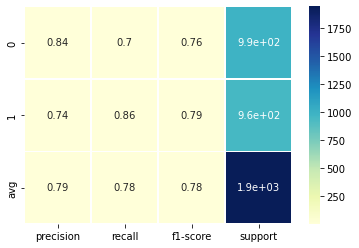

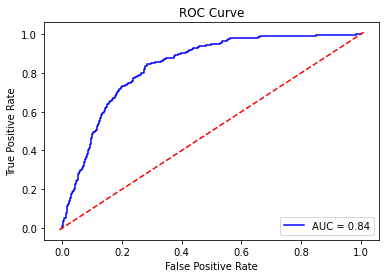

In [4]:
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression()
lr_param = {
    'solver': ['newton-cg', 'lbfgs', 'liblinear'],
    'penalty':['l1', 'l2', 'none', 'elasticnet'],
    'C': np.logspace(0, 5, 10)
}
evaluation(lr_model, lr_param)

## ii. Random Forest

Fitting 3 folds for each of 50 candidates, totalling 150 fits
classification report (train):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3872
           1       1.00      1.00      1.00      3905

    accuracy                           1.00      7777
   macro avg       1.00      1.00      1.00      7777
weighted avg       1.00      1.00      1.00      7777

classification report (test):
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       989
           1       0.99      1.00      1.00       956

    accuracy                           1.00      1945
   macro avg       1.00      1.00      1.00      1945
weighted avg       1.00      1.00      1.00      1945

scores (test):
	accuracy: 1.00
	precision: 0.99
	recall: 1.00
	f1: 1.00
	roc auc: 1.00


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  3.9min finished


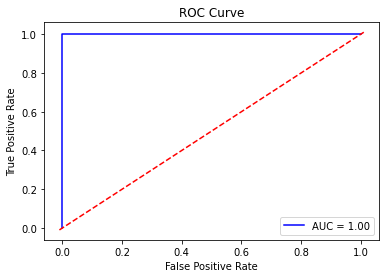

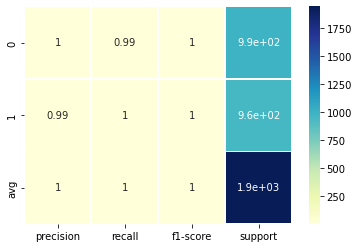

In [5]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier()
rf_param = {
    'n_estimators': list(range(200, 2200, 200)),
    'max_features': ['auto', 'sqrt'],
    'max_depth': list(range(10, 120, 10)) + [None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}
evaluation(rf_model, rf_param)